# **SemEval: 2025**


# Data Exploration: Hazard and Product Classification

## 1. Introduction
In this notebook, we explore the dataset that will be used for hazard and product classification. The primary steps performed in this analysis include:
- **Loading the dataset**
- **Data cleaning**
- **Exploratory data analysis (EDA)**:
  - Distribution of hazard and product categories
  - Trend of the distribution of hazard and product class labels
  - Length of titles and text

This exploration helps us understand the structure of the data, identify potential issues, and inform decisions on how to approach modeling.


---

**Import the necessary libraries.**

---

In [ ]:
# Install necessary packages
!pip install datasets
!pip install imblearn


In [ ]:

# Data manipulation and analysis
import numpy as np
import pandas as pd  # For loading and processing data

# Text processing and NLP
import re  # For regex-based text cleaning
import nltk
from nltk.corpus import stopwords  # For removing stopwords
from nltk.stem import WordNetLemmatizer  # For lemmatization
from sklearn.feature_extraction.text import TfidfVectorizer  # For TF-IDF vectorization

# Machine Learning
from sklearn.model_selection import train_test_split  # For train-test split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Transformers and Datasets
from datasets import Dataset
from transformers import AutoTokenizer

# System and Utilities
import os

# Download necessary NLTK resources
nltk.download('stopwords')  # Download stopwords
nltk.download('wordnet')     # Download WordNet for lemmatizer
nltk.download('omw-1.4')


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer




c:\Users\magda\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\magda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\magda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

---

**Load the datasets.**

---


## Dataset Overview

CSV files for this challenge:

1. **Train Labeled Dataset**:
   - Contains labeled data with text features (e.g., title or full text) and their corresponding labels (`hazard-category`, `product-category`).

2. **Validation Unlabeled Dataset**:
   - Includes unlabeled data used to evaluate the model’s performance during training.


### Next Steps
Load the CSV files to explore and preprocess the data.


In [ ]:
# Load Data
labeled_data_path = 'labeled_trial-training_data(5028samples).csv'
validation_data_path = 'unlabeled_validation_data(565).csv'

# Load training and validation data
train_data = pd.read_csv(labeled_data_path)
validation_data = pd.read_csv(validation_data_path)

# Inspect the first few rows
print("Train Data Sample:")
train_data.head()


Train Data Sample:


,Unnamed: 0,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


---

**Data Cleaning**

---

## Text Preprocessing for Model Training

To prepare the text data for analysis or model training, we cleaned the text through several preprocessing steps. These steps ensure the data is consistent and ready for feature extraction or classification tasks.

### Preprocessing Steps
1. **Initialization**:
   - **Stopwords**: A predefined list of common English words (e.g., "the", "is", "and") that add little value for text classification tasks.
   - **Lemmatizer**: Reduces words to their base form (e.g., "running" → "run") for better recognition by models.

2. **Cleaning Function**: Defined a function, `clean_text`, that performs:
   - **Lowercasing**: Converts all text to lowercase, ensuring consistency.
   - **Removing Special Characters**: Eliminates non-alphanumeric characters (e.g., punctuation).
   - **Removing Numbers**: Filters out numerical values irrelevant to the task.
   - **Stopwords Removal and Lemmatization**: Removes stopwords and applies lemmatization to each word.

3. **Application**:
   - Applied the `clean_text` function to the `title` column of the dataset.
   - Saved the cleaned dataset into a CSV file for further use.

### Output
The cleaned text data is now ready for feature extraction or direct input into machine learning models.


In [7]:
## Data Cleaning
# Initialize Stopwords and Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)      # Remove numbers (customize if needed)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Clean titles and text for both datasets
for dataset in [train_data, validation_data]:
    dataset['cleaned_title'] = dataset['title'].apply(clean_text)
    dataset['cleaned_text'] = dataset['text'].apply(clean_text)

# Add lengths for EDA
train_data['title_length'] = train_data['cleaned_title'].apply(lambda x: len(x.split()))
train_data['text_length'] = train_data['cleaned_text'].apply(lambda x: len(x.split()))

## Data Cleaning and Preparation

### Key Steps
1. Selected important columns:
   - **Labels**: `hazard-category`, `product-category`
   - **Details**: `hazard`, `product`
   - **Text Features**: `cleaned_title` → `title`, `cleaned_text` → `text`
2. Retained and renamed columns for training and validation data.

### Saving Data
- **Cleaned Training Data**: Saved as `cleaned_train_data.csv`.
- **Cleaned Validation Data**: Saved as `cleaned_validation_data.csv`.


In [ ]:

# Select important columns
important_columns = [                            # Metadata (if relevant)
    'hazard-category', 'product-category',       # Labels
    'hazard', 'product',                         # Specific hazard/product labels
    'cleaned_title', 'cleaned_text'              # Cleaned text
]

# Retain only the important columns
train_data_cleaned = train_data[important_columns].rename(
    columns={'cleaned_title': 'title', 'cleaned_text': 'text'}
)
validation_data_cleaned = validation_data[['cleaned_title', 'cleaned_text']].rename(
    columns={'cleaned_title': 'title', 'cleaned_text': 'text'})
train_data_cleaned.head()



# Save the cleaned training data to a CSV file
train_data_cleaned.to_csv('cleaned_train_data.csv', index=False)
print("Cleaned training data saved as 'cleaned_train_data.csv'.")

# Save the cleaned validation data to a CSV file
validation_data_cleaned.to_csv('cleaned_validation_data.csv', index=False)
print("Cleaned validation data saved as 'cleaned_validation_data.csv'.")

Cleaned training data saved as 'cleaned_train_data.csv'.
Cleaned validation data saved as 'cleaned_validation_data.csv'.


---

Exploratory Data Analysis

---

## Data Visualization

### 1. Hazard Category Distribution
The following bar chart visualizes the distribution of different `hazard-category` labels in the dataset. 

**Key Observations**:
- **Allergens** and **biological** hazards are the most frequent categories.
- Categories such as **food additives and flavourings** and **migration** are significantly less represented, highlighting a class imbalance.

### 2. Product Category Distribution
This bar chart depicts the distribution of `product-category` labels across the dataset.

**Key Observations**:
- **Meat, egg, and dairy products** are the most frequently reported category, followed by **cereals and bakery products**.
- Several categories such as **fats and oils**, **honey and royal jelly**, and **sugars and syrups** have very few records, reflecting a need for balancing in the dataset.



C:\Users\magda\AppData\Local\Temp\ipykernel_18160\20121510.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


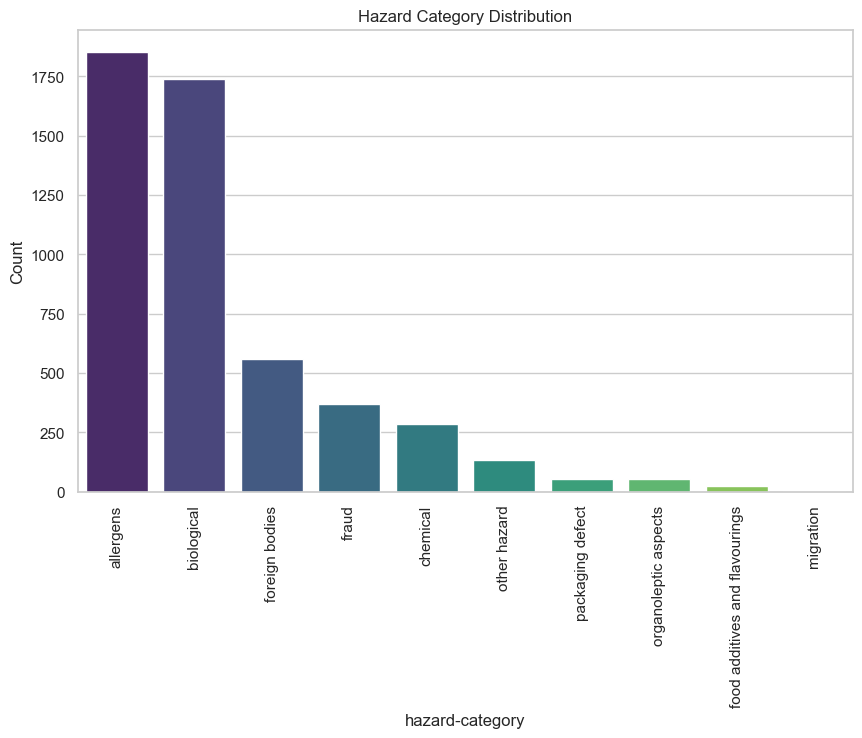

C:\Users\magda\AppData\Local\Temp\ipykernel_18160\20121510.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


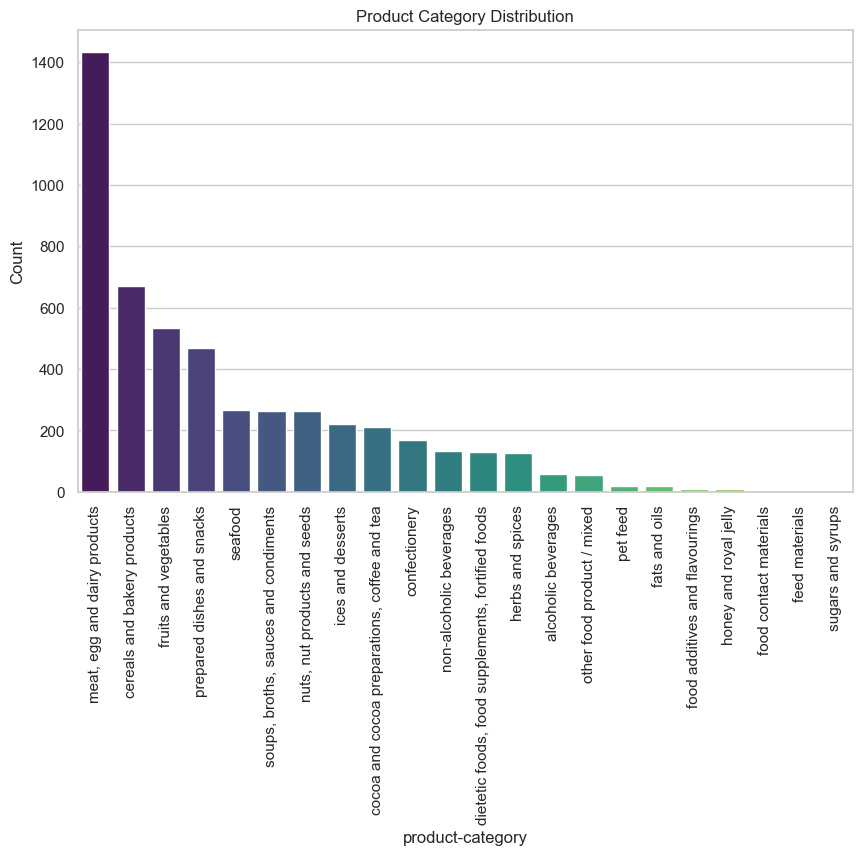

In [ ]:
# Function to plot the distribution of a specified categorical column
def plot_category_distributions(data, category, title):
    counts = data[category].value_counts()  # Count unique values in the category
    plt.figure(figsize=(10, 6))  # Set plot size
    sns.barplot(x=counts.index, y=counts.values, palette="viridis")  # Create bar plot
    plt.title(f"{title} Distribution")  # Set plot title
    plt.xticks(rotation=90)  # Rotate x-axis labels
    plt.xlabel(category)  # Set x-axis label
    plt.ylabel("Count")  # Set y-axis label
    plt.show()  # Display the plot

# Plot distributions for "hazard-category" and "product-category"
plot_category_distributions(train_data, "hazard-category", "Hazard Category")
plot_category_distributions(train_data, "product-category", "Product Category")


## Top 20 Most Frequent Hazards and Products

### 1. **Hazard Subplot**
The chart below highlights the top 20 most frequent hazards in the dataset. 

**Key Observations**:
- Hazards like **Listeria monocytogenes**, **Salmonella**, and **Milk and products thereof** dominate the dataset with significantly higher counts compared to others.
- The distribution follows a long-tail pattern, indicating that most hazards are relatively rare.

**Styling Features**:
- The dot size and gridlines enhance clarity.
- A **coolwarm** color palette emphasizes high-frequency hazards, with warm colors (reds) drawing attention to critical hazards like Listeria and Salmonella.
- Counts are annotated next to the dots for precision.

### 2. **Product Subplot**
The chart below showcases the top 20 most frequently associated products.

**Key Observations**:
- Products such as **Ice Cream** and **Chicken-based products** are significantly more associated with hazards compared to others.
- The distribution is skewed, with the majority of products having low counts and a few standing out with high frequencies.

**Styling Features**:
- A **viridis** color palette is used for its colorblind-friendly properties, where bright green represents higher counts.
- Counts are annotated near the dots for added clarity.

C:\Users\magda\AppData\Local\Temp\ipykernel_18160\72719554.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


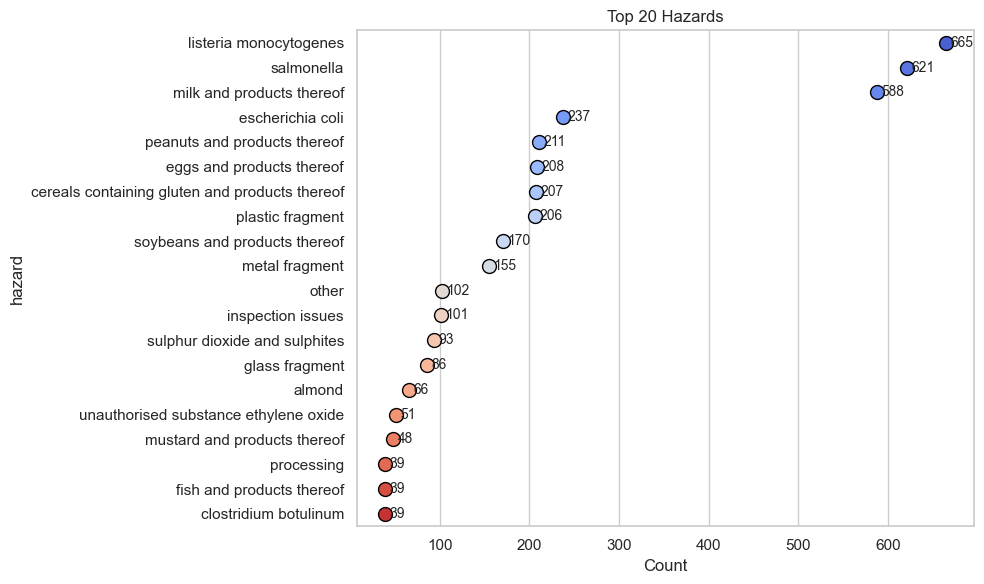

C:\Users\magda\AppData\Local\Temp\ipykernel_18160\72719554.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


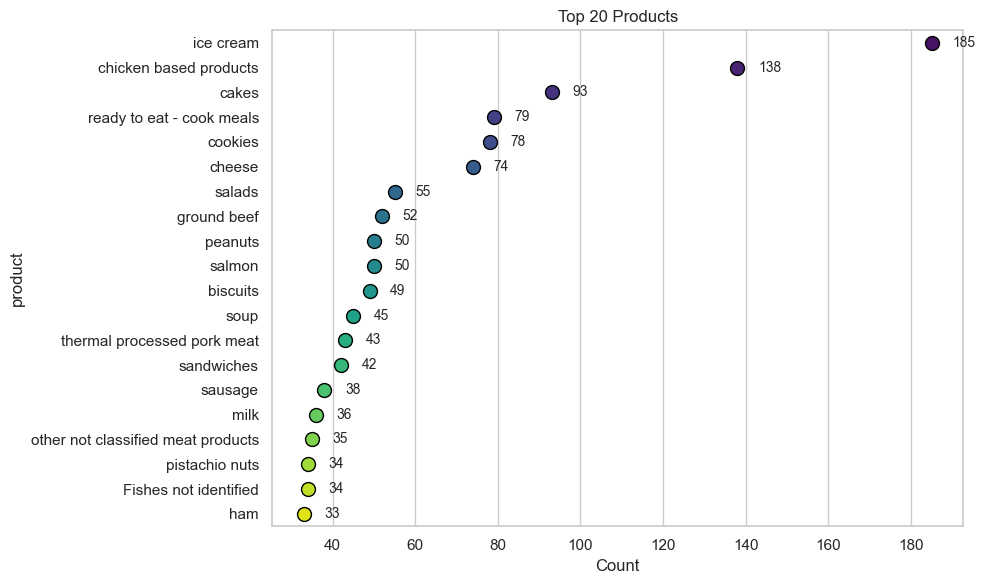

In [ ]:
# Function: plot_top_n
# Purpose: Visualize the top N most frequent values in a specified column using a horizontal strip plot.
# Inputs:
#   - data: The dataframe containing the data to analyze.
#   - column: The name of the column to analyze.
#   - n: The number of top values to display (default is 20).
#   - title: Title for the plot (default is an empty string).
#   - palette: Color palette for the plot (default is "viridis").
def plot_top_n(data, column, n=20, title="", palette="viridis"):
    # Get the top N most frequent values in the specified column
    top_counts = data[column].value_counts().head(n)
    
    # Set the size of the plot
    plt.figure(figsize=(10, 6))
    
    # Create a horizontal strip plot to display frequency
    sns.stripplot(
        y=top_counts.index,       # Categories on the y-axis
        x=top_counts.values,      # Frequency counts on the x-axis
        palette=palette,          # Color palette for the points
        size=10,                  # Size of the points
        linewidth=1,              # Border width around the points
        edgecolor="black",        # Border color of the points
        orient="h"                # Orientation: horizontal
    )
    
    # Set the title and axis labels
    plt.title(title)             # Title of the plot
    plt.xlabel("Count")          # Label for the x-axis
    plt.ylabel(column)           # Label for the y-axis
    
    # Add the exact count as a text label next to each point
    for i, count in enumerate(top_counts.values):
        plt.text(count + 5, i, str(count), va="center", ha="left", fontsize=10)
    
    # Adjust layout to prevent overlapping labels or titles
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Plot the top 20 most frequent values in the "hazard" column
plot_top_n(train_data, "hazard", n=20, title="Top 20 Hazards", palette="coolwarm")

# Plot the top 20 most frequent values in the "product" column
plot_top_n(train_data, "product", n=20, title="Top 20 Products", palette="viridis")


## Title and Text Length Analysis

### 1. **Title Lengths Plot**
The histogram below shows the distribution of the number of words in the `title` field.

**Key Observations**:
- The mean title length is **10 words**, indicating that most titles are concise.
- The majority of titles range between **5 and 20 words**.
- The peak (mode) suggests that the majority of titles have **10–15 words**, with very few titles exceeding **20 words**.


### 2. **Text Lengths Plot**
The histogram below illustrates the distribution of the number of words in the `text` field.

**Key Observations**:
- The mean text length is **216 words**, with a right-skewed distribution.
- Most texts are under **500 words**, while a few outliers exceed **1,000 words**.
- The significant variation in text lengths may require preprocessing steps like truncation or padding for consistency in modeling.


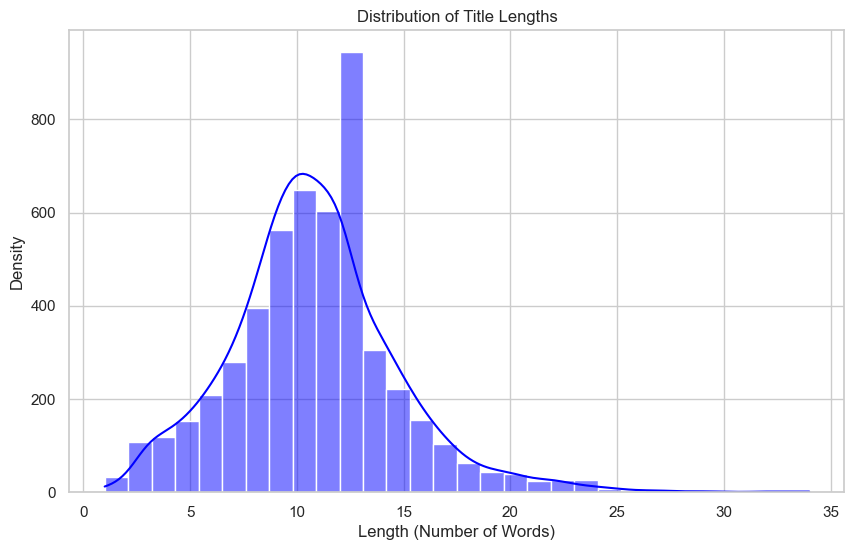

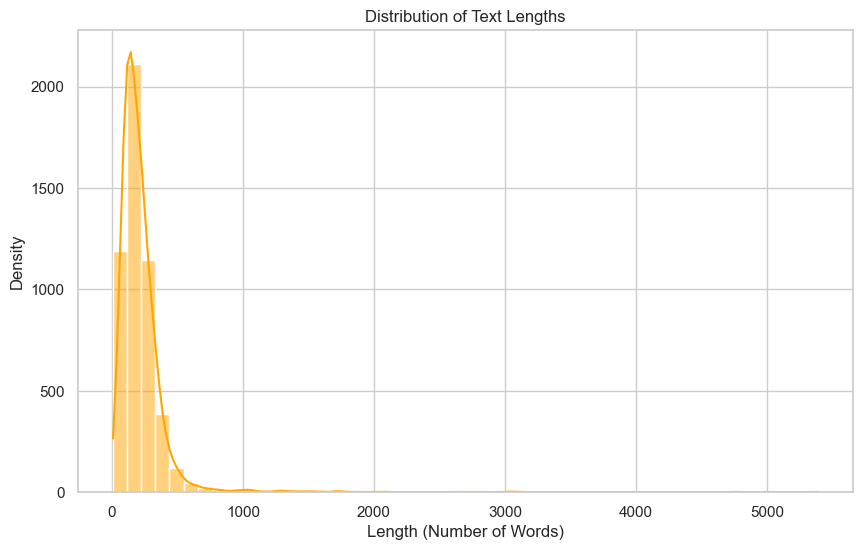

In [ ]:
# Function to plot the distribution of lengths for a specified column
def plot_length_distribution(data, column, title, bins=30, color="blue"):
    plt.figure(figsize=(10, 6))  # Set the plot size
    sns.histplot(data[column], bins=bins, kde=True, color=color)  # Create a histogram with KDE overlay
    plt.title(title)  # Set the plot title
    plt.xlabel("Length (Number of Words)")  # Label for the x-axis
    plt.ylabel("Density")  # Label for the y-axis
    plt.show()  # Display the plot

# Plot the distribution of title lengths
plot_length_distribution(train_data, "title_length", "Distribution of Title Lengths", bins=30, color="blue")

# Plot the distribution of text lengths
plot_length_distribution(train_data, "text_length", "Distribution of Text Lengths", bins=50, color="orange")


## Calculating Mean Lengths for Titles and Texts

To better understand the dataset, we calculated the mean lengths of the `title` and `text` fields. These averages provide insights into the typical size of each text entry, aiding in preprocessing and model design.

#### **Results:**
- Mean Text Length: 216 words
- Mean Title Length: 10 words

These statistics confirm that while the full texts have significant variability, titles are typically concise, with a much smaller average length. This difference may necessitate separate preprocessing strategies for titles and full texts.

In [62]:


# Calculate mean for text length
# Compute the average number of words in the 'text' column.
mean_text_length = train_data["text_length"].mean()
print(f"Mean Text Length: {int(mean_text_length)}")  # Print the mean text length as an integer.

mean_title_length = train_data["title_length"].mean()
print(f"Mean Text Length: {int(mean_title_length)}")  # Print the mean text length as an integer.




Mean Text Length: 216
Mean Text Length: 10


### **Summary of Findings from Preprocessing and Exploratoty Data Analysis**

#### **Class Distributions**
1. **Hazard Categories**:
   - Some categories dominate the dataset.
   - Others are underrepresented, reflecting an imbalanced distribution.

2. **Product Categories**:
   - Categories like "meat, egg and dairy products" appear frequently.
   - Similar imbalances as seen with hazard categories.

3. **Hazards**:
   - A few hazards, like Listeria monocytogenes and Salmonella, dominate the dataset with high frequencies.
   - Most other hazards have much lower counts, creating a long tail with many rare hazards.

4. **Products**:
   - A small number of products, such as Ice Cream and Chicken-based products, have significantly higher counts.
   - Other products are much less frequent, showing a skewed distribution with many products having low counts.



#### **Text and Titles Lengths**
1. **Titles**:
   - Typically concise, averaging **10 words**.
   - Ideal for short-text classification tasks.

2. **Texts**:
   - Richer in detail, averaging **216 words**.
   - Suitable for more complex analysis and classification.